# Bootstrap demo: multivariable KDE-resampling

##### sample code to demonstrate the functionality of multi-variate KDE-resampling for the WUS forest mortality bootstrap

The overall goal of using a Kernel Density Estimator (KDE) to resample control pixels is to create a set of control pixels which have a similar distribution of key landscape variables as the mortality pixels. There are several key considerations here:

1. Since the goal is to match distributions, we can use the Kolmogorov-Smirnov (K-S) statistical test which tests whether two samples are likely to have been drawn from the same distribution. However, the effectiveness of this process depends on the number of random draws (sample size) from the control.  Even for two sets of values randomly drawn from the same distribution, a large enough sample size from one of the distributions will eventually convince the K-S test that the two sets are different. We must test a variety of sample sizes to find how many random draws is too many.

2. When we are combining many variables to be fit/matched by their KDEs, or if the mortality pixel count is small, we might limit ourselves to a very small remaining pool of control pixels. It's important to understand how the filtering influences the selection of these control pixels, their geographic distribution, etc.

3. Both of these considerations will vary depending on the set of mortality pixels we begin with for defining the KDEs. Because we are curious about the analysis' sensitivity to the severity of mortality, we should test the first two considerations for a variety of input mortality pixels.


#### This demo is a follow-up to part 1 of the KDE demo, named 03_multivar_KDE_demo_resample_size_sensitivity.ipynb
#### In this notebook we will specifically focus on consideration number 2 (the resulting number of pixels after filtering).
Consideration number 3 can be tested by modifying the path of the mortality pixels in the code below

### Variables used for KDE-resampling:
- NASA SRTM elevation
- MODIS LAI (July mean)
- Tree Canopy Cover (TCC) from the National Land Cover Database (NLCD).

Preliminary setup - load packages, define filepaths, functions, global variables, etc.

In [14]:
#########################################
# Load packages
#########################################

import os  # operating system library
import sys

# numerical/data management packages
import numpy as np
import xarray as xr  # for multi dimensional data
import pandas as pd

# shapefile/geospatial packages
import geopandas as gpd
from shapely.geometry import mapping
# from sklearn.neighbors import KernelDensity

from scipy.stats import gaussian_kde
from scipy.stats import ks_2samp

# time and date packages
import time
from datetime import datetime as dt  # date time library
from datetime import timedelta

# plotting packages
from matplotlib import pyplot as plt  # primary plotting module
import cartopy.crs as ccrs  # spatial plotting library 
from cartopy.io import img_tiles  # cartopy's implementation of webtiles
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter as FFmt  # need this for formatting plot ticks



#########################################
# Define Global Filepaths
#########################################

# Elevation, Tree Canopy Cover and LAI datasets
elev_file = 'include/SRTM_DEM_05d_WUS.nc'
TCC_file = 'include/NLCD_TCC_05d_WUS_2021.nc'
LAI_July_file = 'include/MODIS_LAI_WUS_05d_2011-2023_July_mean.nc'


# mortality/control shapefiles
control_polygon_filepath = 'include/control_pixels.shp'
mortality_polygon_filepath = 'include/mortality_pixels_gt40p.shp' # MODIFY THIS TO SELECT A DIFFERENT THRESHOLD OF MORTALITY SEVERITY

########################################
# Define Global Variables and constants
#########################################

elevation_bin = 100 # meters
elevation_range = np.linspace(0, 4000, 1000)
LAI_bin = 0.25 # unitless
LAI_range = np.linspace(0, 8, 1000)
TCC_bin = 5 # percent
TCC_range = np.linspace(-20, 120, 1000)

#########################################
# Define Global Functions
#########################################

# matplotlib map plotting functions
def z_axis_formatter(x, pos, deci=2):
   '''Format ticks to format with deci number of decimals'''

   return f'{x:.{deci}f}'

#########################################
# Define map parameters 
#########################################

# use Google Satellite imagery as basemap
tiler = img_tiles.GoogleTiles(style='satellite')
crs = tiler.crs # set crs of map tiler
alpha = 1  # transparency 0-1
transform = ccrs.PlateCarree()  # transform specifies the crs that the data is in


### Load state boundaries
fn = shpreader.natural_earth(
   resolution='10m', category='cultural', 
   name='admin_1_states_provinces',
)
reader = shpreader.Reader(fn)
states = [x for x in reader.records() if x.attributes["admin"] == "United States of America"] # get all states in US
states_geom = cfeature.ShapelyFeature([x.geometry for x in states], ccrs.PlateCarree())
tiler_zoom = 7  # define a zoom level of detail
extent =  [-125, -118, 36, 44]  # [minx, maxx, miny, maxy], bounds for western US



#### Load datasets and plot maps to visualize

In [10]:
# Load SRTM elevation
elev_rxr = xr.open_dataset(elev_file).squeeze('band').rename({'lon':'x', 'lat':'y'}).sortby(['x', 'y'])
elev_rxr.rio.write_crs(4326, inplace = True) # specify WGS84 as CRS

# Load MODIS LAI July means
LAI_rxr = xr.open_dataarray(LAI_July_file).sortby(['x', 'y']) # Assume grid matches with elevation dataset (already checked)
LAI_rxr.rio.write_crs(4326, inplace = True) # specify WGS84 as CRS

# Load NLCD Tree Canopy Cover
TCC_rxr = xr.open_dataset(TCC_file).squeeze('band').rename({'lon':'x', 'lat':'y'}).sortby(['x', 'y']) # Assume grid matches with elevation dataset (already checked)
TCC_rxr.rio.write_crs(4326, inplace = True) # specify WGS84 as CRS

# Load mortality pixels shapefile
mortality_polygon_gdf = gpd.read_file(mortality_polygon_filepath)
mortality_polygon_geom = mortality_polygon_gdf.geometry.apply(mapping)
num_mortality_pixels = len(mortality_polygon_gdf)

# load control pixels shapefile
control_polygon_gdf = gpd.read_file(control_polygon_filepath)
control_polygon_geom = control_polygon_gdf.geometry.apply(mapping)
num_control_pixels = len(control_polygon_geom)

# Clip datasets to mortality and control domains
elev_rxr_mortality_clip = elev_rxr.rio.clip(mortality_polygon_geom, crs=4326) # filter for disturb domain
elev_rxr_control_clip = elev_rxr.rio.clip(control_polygon_geom, crs=4326) # filter for healthy domain
LAI_rxr_mortality_clip = LAI_rxr.rio.clip(mortality_polygon_geom, crs=4326) # filter for disturb domain
LAI_rxr_control_clip = LAI_rxr.rio.clip(control_polygon_geom, crs=4326) # filter for healthy domain
TCC_rxr_mortality_clip = TCC_rxr.rio.clip(mortality_polygon_geom, crs=4326) # filter for disturb domain
TCC_rxr_control_clip = TCC_rxr.rio.clip(control_polygon_geom, crs=4326) # filter for healthy domain

# define the healthy domain dataset shape (should be the same for all datasets)
orig_dataset_shape = elev_rxr_control_clip.elevation.shape


##### Process data for bootstrapping

In [12]:
# Flatten the datasets
elev_mortality_flat = elev_rxr_mortality_clip.elevation.data.flatten()
elev_control_flat = elev_rxr_control_clip.elevation.data.flatten()
LAI_mortality_flat = LAI_rxr_mortality_clip.data.flatten()
LAI_control_flat = LAI_rxr_control_clip.data.flatten()
TCC_mortality_flat = TCC_rxr_mortality_clip.tree_canopy_cover.data.flatten()
TCC_control_flat = TCC_rxr_control_clip.tree_canopy_cover.data.flatten()

# Get indices of non-NaN values - Elev
non_nan_indices_disturb = ~np.isnan(elev_mortality_flat)
non_nan_indices_healthy = ~np.isnan(elev_control_flat)
# Filter the datasets to include only non-NaN values
elev_mortality_non_nan = elev_mortality_flat[non_nan_indices_disturb]
elev_control_non_nan = elev_control_flat[non_nan_indices_healthy]
elev_control_mean = np.mean(elev_control_non_nan) # get mean for later scaling

# Get indices of non-NaN values - LAI
non_nan_indices_disturb = ~np.isnan(LAI_mortality_flat)
non_nan_indices_healthy = ~np.isnan(LAI_control_flat)
# Filter the datasets to include only non-NaN values
LAI_mortality_non_nan = LAI_mortality_flat[non_nan_indices_disturb]
LAI_control_non_nan = LAI_control_flat[non_nan_indices_healthy]
LAI_control_mean = np.mean(LAI_control_non_nan) # get mean for later scaling

# Get indices of non-NaN values - TCC
non_nan_indices_disturb = ~np.isnan(TCC_mortality_flat)
non_nan_indices_healthy = ~np.isnan(TCC_control_flat)
# Filter the datasets to include only non-NaN values
TCC_mortality_non_nan = TCC_mortality_flat[non_nan_indices_disturb]
TCC_control_non_nan = TCC_control_flat[non_nan_indices_healthy]
TCC_control_mean = np.mean(TCC_control_non_nan) # get mean for later scaling

# Fit Kernel Density Estimators using gaussian_kde for all vars
elev_mortality_kde = gaussian_kde(elev_mortality_non_nan, bw_method = 'scott')
LAI_mortality_kde = gaussian_kde(LAI_mortality_non_nan, bw_method = 'scott')
TCC_mortality_kde = gaussian_kde(TCC_mortality_non_nan, bw_method = 'scott')

# Evaluate KDE for density estimation
elev_mortality_density = elev_mortality_kde.evaluate(elevation_range)
lai_mortality_density = LAI_mortality_kde.evaluate(LAI_range)
TCC_mortality_density = TCC_mortality_kde.evaluate(TCC_range)

# Fit Kernel Density Estimators using gaussian_kde for all vars
elev_control_kde = gaussian_kde(elev_control_non_nan, bw_method = 'scott')
lai_control_kde = gaussian_kde(LAI_control_non_nan, bw_method = 'scott')
TCC_control_kde = gaussian_kde(TCC_control_non_nan, bw_method = 'scott')

# Evaluate KDE for density estimation
elev_control_density = elev_control_kde.evaluate(elevation_range)
lai_control_density = lai_control_kde.evaluate(LAI_range)
TCC_control_density = TCC_control_kde.evaluate(TCC_range)




Now we will define a function which will help us understand the number of pixels which are actually sampled when we use multiple variables' KDEs for filtering. We will also plot a heatmap of the resampling frequency of the control pixels. 

In [22]:
#########################################
# Define KDE resampling function
#########################################

def test_KDE_pixel_selection(control_sample_size, fit_elevation = True, fit_LAI = False, fit_TCC = False):

   # function start time
   start_time = time.time()

   sampleCount_xr_arr = []
   num_selected_pixels_arr = []

   # Repeat the resampling process 100 times
   for num_repeat in range(100):
      # print(f'Iteration {num_repeat+1}')

      # Sample new values based on the densities (note, only those flagged by input booleans will be used)
      sampled_elev_values = elev_mortality_kde.resample(control_sample_size).flatten()
      sampled_lai_values = LAI_mortality_kde.resample(control_sample_size).flatten()
      sampled_TCC_values = TCC_mortality_kde.resample(control_sample_size).flatten()

      # Find indices in the control domain where both elevation and LAI match closely
      matching_indices = []
      control_polygon_gdf_KDE_FILTER = gpd.GeoDataFrame(columns=control_polygon_gdf.columns, crs=control_polygon_gdf.crs)
      sampleCount_xr = xr.DataArray(
         0,  # fill with NaNs
         coords=elev_rxr.coords,  # use the same coordinates
         dims=elev_rxr.dims,  # use the same dimensions
         attrs=elev_rxr.attrs  # copy attributes
      )

      for elev_val, lai_val, TCC_val in zip(sampled_elev_values, sampled_lai_values, sampled_TCC_values):
         # Calculate the normalized differences of each var
         elev_diffs = np.abs(elev_control_flat - elev_val)/elev_control_mean # divide by mean to normalize
         LAI_diffs = np.abs(LAI_control_flat - lai_val)/LAI_control_mean # divide by mean to normalize
         TCC_diffs = np.abs(TCC_control_flat - TCC_val)/TCC_control_mean # divide by mean to normalize
         
         # Combine constraints: find indices where combined differences are minimal
         overall_diffs = np.zeros(len(elev_diffs))
         if fit_elevation:
            overall_diffs += elev_diffs
         if fit_LAI:
            overall_diffs += LAI_diffs
         if fit_TCC:
            overall_diffs += TCC_diffs 

         matching_idx = np.nanargmin(overall_diffs) # identify the index of the minimum difference
         
         # Append the index if not already present (retains only unique pixels)
         if matching_idx not in matching_indices:
            matching_indices.append(matching_idx)

      # Convert the original indices to unique x/y coordinates
      sampled_coords = np.unravel_index(matching_indices, orig_dataset_shape)

      # Extract x and y coordinates as indices from the original datasets' grid
      sampled_x_icoords = sampled_coords[1]
      sampled_y_icoords = sampled_coords[0]

      # Loop through the sampled coordinates and recreate the gridded points where elevations were selected
      for ii in range(len(sampled_x_icoords)):
         x_coord = elev_rxr_control_clip.x.values[sampled_x_icoords[ii]]
         y_coord = elev_rxr_control_clip.y.values[sampled_y_icoords[ii]]

         # Find the closest point in control_polygon_gdf for each x, y coordinate pair
         distances = control_polygon_gdf.geometry.apply(lambda geom: geom.distance(gpd.points_from_xy([x_coord], [y_coord])[0]))
         closest_point_index = distances.idxmin()
         closest_point = control_polygon_gdf.loc[closest_point_index]
         
         # Filter control_polygon_gdf for points that are matched to these sets of coordinates
         control_polygon_gdf_KDE_FILTER = pd.concat([control_polygon_gdf_KDE_FILTER, closest_point.to_frame().T])

      # control_polygon_gdf_KDE_FILTER is now just like control_polygon_gdf but with a similar distrib to mortality pixels
      num_control_pixels = len(control_polygon_gdf_KDE_FILTER)
      num_selected_pixels_arr.append(num_control_pixels)

      # THIS IS OFFICIALLY WHERE BOOTSTRAP RESAMPLING WITH REPLACEMENT OCCURS
      # Randomly sample rows of the mortality_polygon_gdf object
      control_polygon_gdf_sampled = control_polygon_gdf_KDE_FILTER.sample(num_control_pixels, replace=True)

      for pixel_center in control_polygon_gdf_sampled.centroid:
         # Find the x, y coordinate in sampleCount_xr that corresponds to closest_point
         closest_point_x = pixel_center.x
         closest_point_y = pixel_center.y

         # Find the index of the closest x, y coordinate in sampleCount_xr
         x_index = np.argmin(np.abs(sampleCount_xr.x.values - closest_point_x))
         y_index = np.argmin(np.abs(sampleCount_xr.y.values - closest_point_y))

         # Increment the value of that pixel in sampleCount_xr by one
         sampleCount_xr.values[y_index, x_index] += 1
   
      sampleCount_xr_arr.append(sampleCount_xr.expand_dims(iter = [num_repeat]))

   sampleCount_xr_mean = xr.concat(sampleCount_xr_arr, dim = 'iter').mean(dim = 'iter')
   num_selected_pixels_mean = np.mean(num_selected_pixels_arr)
   print(f'Average number of unique pixels selected within given repitition: {np.round(num_selected_pixels_mean)}')

   # Scale the sampleCount_xr_mean from 0 to 1 by dividing by the maximum value
   sampleCount_xr_mean_scaled = sampleCount_xr_mean / sampleCount_xr_mean.max()

   sampleCount_rxr_clip = sampleCount_xr_mean_scaled.where(sampleCount_xr_mean_scaled > 0)
   num_resulting_control_pixels = len(sampleCount_rxr_clip.values[~np.isnan(sampleCount_rxr_clip.values)])
   print(f'Total number of unique pixels selected across all repititions: {num_resulting_control_pixels}')

   elev_rxr_control_clip_unused = elev_rxr_control_clip.elevation.where(sampleCount_xr_mean_scaled == 0)

   # Plot the heatmap of control pixel frequency of being selected in the KDE resampling
   plt.figure(figsize=(10, 8))
   ax = plt.axes(projection=crs)
   ax.set_extent(extent, crs=transform)
   ax.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)

   # Plot heatmap
   heatmap = ax.pcolormesh(
      sampleCount_rxr_clip.x, sampleCount_rxr_clip.y, sampleCount_rxr_clip,
      transform=transform, cmap='winter_r', alpha=0.6
   )
   # Plot the unused control pixels in gray to denote these as discarded from the filter
   unused_control = ax.pcolormesh(
      elev_rxr_control_clip_unused.x, elev_rxr_control_clip_unused.y, 
      np.where(~np.isnan(elev_rxr_control_clip_unused), 1, np.nan),
      transform=transform, cmap='gray', alpha=0.5
   )

   # Add colorbar
   cbar = plt.colorbar(heatmap, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
   cbar.set_label('Selection frequency (normalized)')

   # Add a gray box to the legend for the unused control pixels
   legend_elements = [Patch(facecolor='gray', edgecolor='gray', label='Control pixels\nnot selected by\nKDE filter')]
   ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(1.23, 0.1), ncol=1)

   # Add title and labels
   plt.title(f'Control domain pixels - average relative frequency of selection')

   # Show plot
   plt.show()

   end_time = time.time()
   print(f'function elapsed time: {timedelta(seconds=end_time-start_time)}')

Now let's test this by fitting various permutations of elevation, LAI and TCC KDEs:

Average number of unique pixels selected within given repitition: 43.0
Total number of unique pixels selected across all repititions: 261


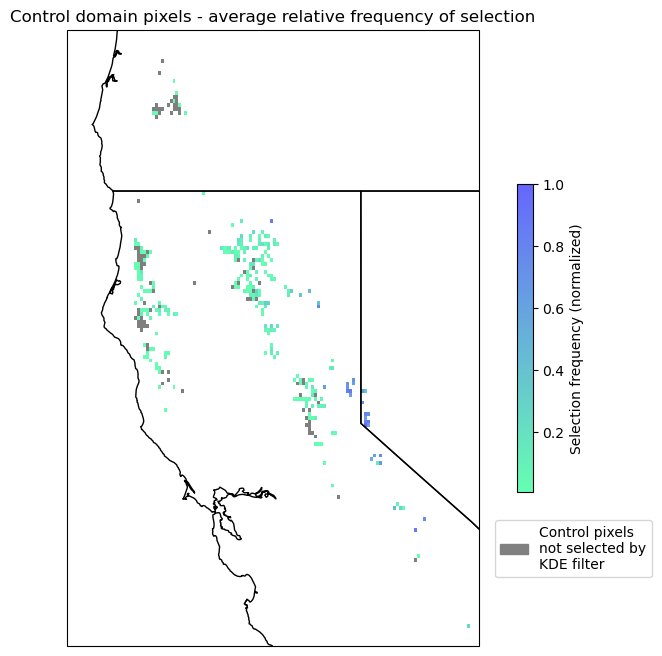

function elapsed time: 0:01:01.484338


In [23]:

# Test elevation-only KDE filter
# control sample size is determined from the number of samples where the elevation p-value line crosses 0.05 from the sensitivity test in Part 1
# if it doesn't cross 0.05 then set control_sample_size = 200
test_KDE_pixel_selection(control_sample_size = 100, fit_elevation = True, fit_LAI = False, fit_TCC = False)

Average number of unique pixels selected within given repitition: 101.0
Total number of unique pixels selected across all repititions: 334


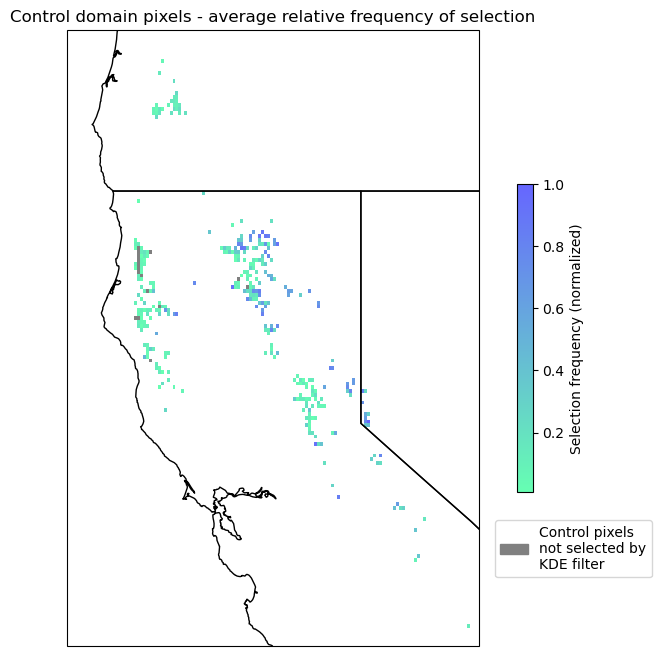

function elapsed time: 0:02:21.355591


In [24]:
# Test LAI-only KDE filter
# control sample size is determined from the number of samples where the LAI p-value line crosses 0.05 from the sensitivity test in Part 1
# if it doesn't cross 0.05 then set control_sample_size = 200
test_KDE_pixel_selection(control_sample_size = 200, fit_elevation = False, fit_LAI = True, fit_TCC = False)

Average number of unique pixels selected within given repitition: 99.0
Total number of unique pixels selected across all repititions: 304


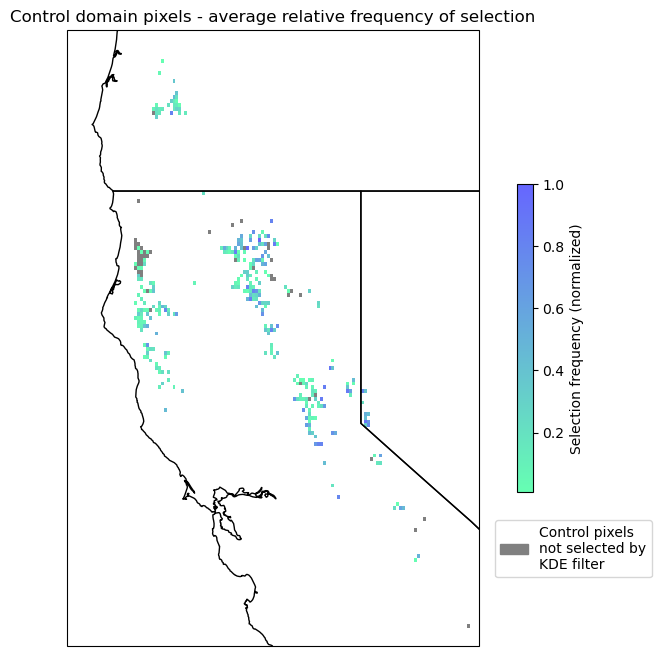

function elapsed time: 0:02:19.555415


In [25]:
# Test TCC-only KDE filter
# control sample size is determined from the number of samples where the TCC p-value line crosses 0.05 from the sensitivity test in Part 1
# if it doesn't cross 0.05 then set control_sample_size = 200
test_KDE_pixel_selection(control_sample_size = 200, fit_elevation = False, fit_LAI = False, fit_TCC = True)

Average number of unique pixels selected within given repitition: 35.0
Total number of unique pixels selected across all repititions: 200


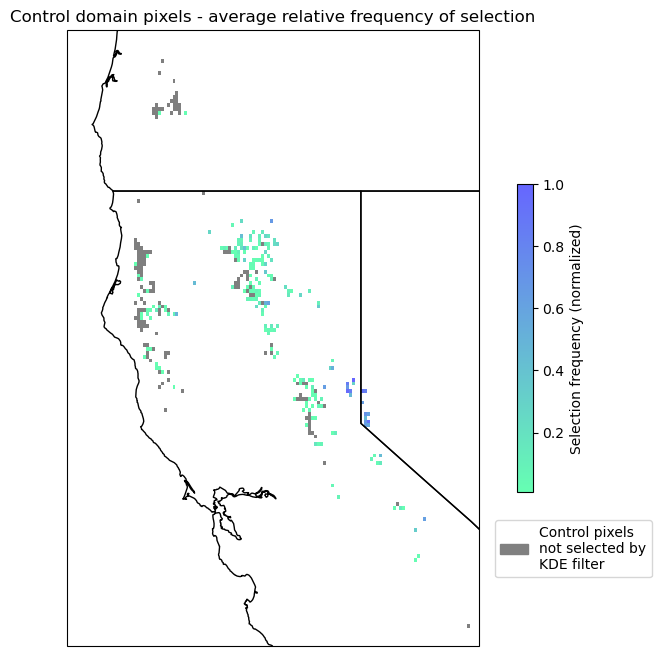

function elapsed time: 0:00:50.480321


In [26]:
# Test elevation and LAI KDE filter
# control sample size is determined from the minimum number of samples where the elevation and LAI p-value lines cross 0.05 from the sensitivity test in Part 1
# if neither crosses 0.05 then set control_sample_size = 200
test_KDE_pixel_selection(control_sample_size = 90, fit_elevation = True, fit_LAI = True, fit_TCC = False)

Average number of unique pixels selected within given repitition: 63.0
Total number of unique pixels selected across all repititions: 243


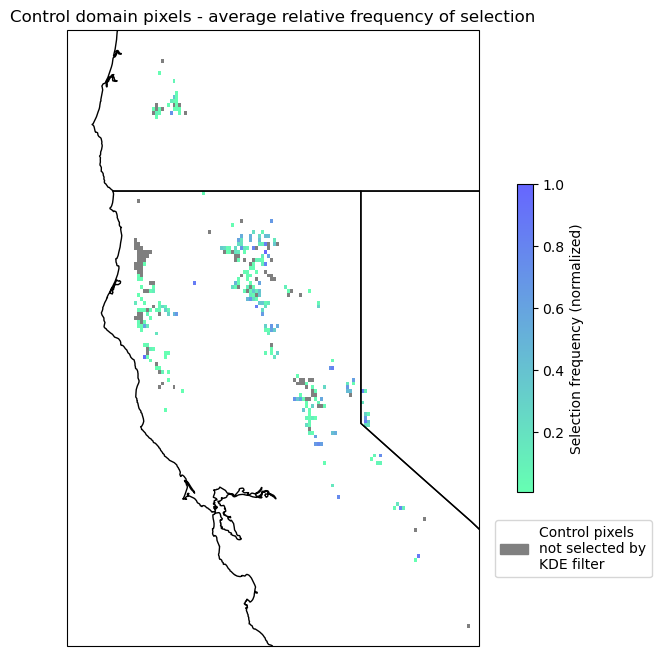

function elapsed time: 0:01:30.070568


In [27]:
# Test LAI and TCC KDE filter
# control sample size is determined from the minimum number of samples where the elevation and TCC p-value lines cross 0.05 from the sensitivity test in Part 1
# if neither crosses 0.05 then set control_sample_size = 200
test_KDE_pixel_selection(control_sample_size = 200, fit_elevation = False, fit_LAI = True, fit_TCC = True)

Average number of unique pixels selected within given repitition: 32.0
Total number of unique pixels selected across all repititions: 193


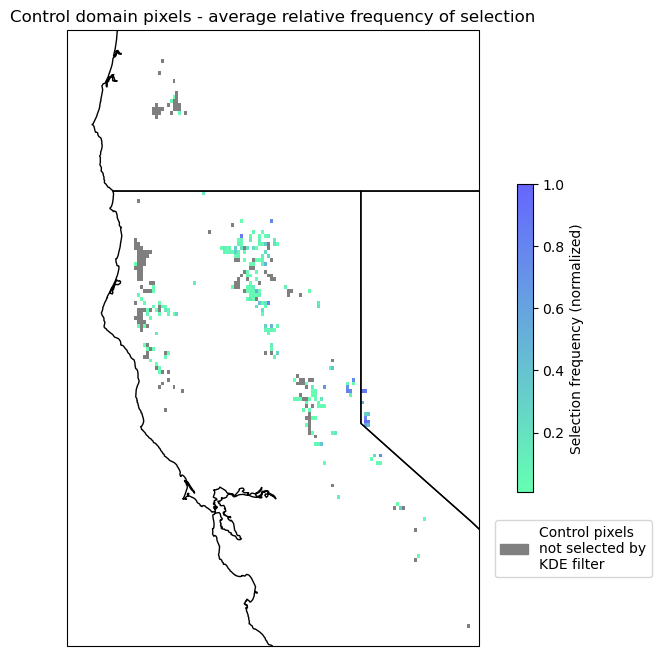

function elapsed time: 0:00:45.276376


In [28]:
# Test elevation and TCC KDE filter
# control sample size is determined from the minimum number of samples where the TCC and LAI p-value lines cross 0.05 from the sensitivity test in Part 1
# if neither crosses 0.05 then set control_sample_size = 200
test_KDE_pixel_selection(control_sample_size = 90, fit_elevation = True, fit_LAI = False, fit_TCC = True)

Average number of unique pixels selected within given repitition: 27.0
Total number of unique pixels selected across all repititions: 144


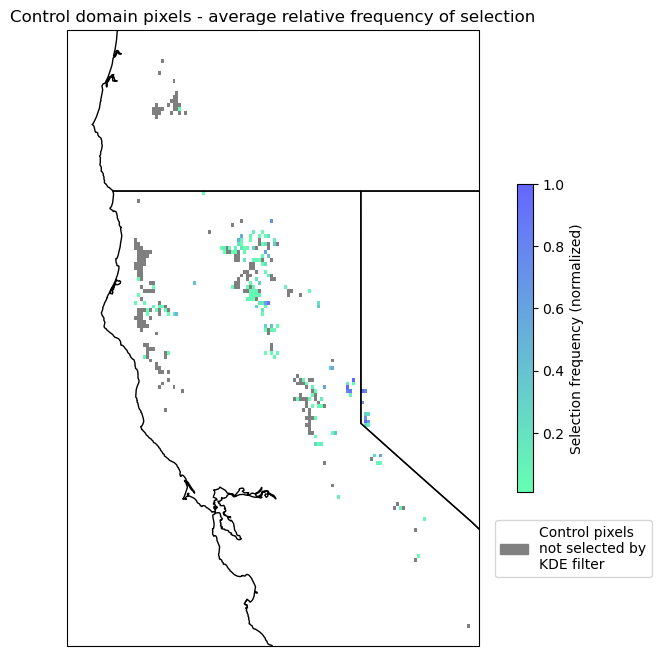

function elapsed time: 0:00:38.897939


In [29]:
# Test all three variables used in KDE filter
# control sample size is determined from the minimum number of samples where the elevation LAI, and TCC p-value lines cross 0.05 from the sensitivity test in Part 1
# if none crosses 0.05 then set control_sample_size = 200
test_KDE_pixel_selection(control_sample_size = 70, fit_elevation = True, fit_LAI = True, fit_TCC = True)